In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import minimize

sns.set(context="talk")

#### Load dataset

In [2]:
data = loadmat("ex4data1.mat")
X = data["X"]
print("X matrix shape =", data["X"].shape)
y = data["y"]
print("y matrix shape =", data["y"].shape)

X matrix shape = (5000, 400)
y matrix shape = (5000, 1)


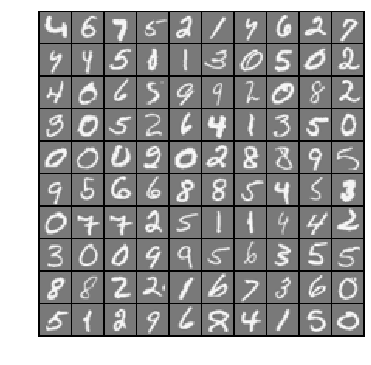

In [3]:
def displayData(X, ex_width=20, figsize=(6, 6)):
    # Compute rows, cols
    m, n = X.shape
    ex_height = n / ex_width
    # Compute number of items to display
    disp_rows = np.floor(np.sqrt(m))
    disp_cols = np.ceil(m/disp_rows)
    # Between images padding
    pad = 1
    # Setup blank display
    disp_array = -np.ones((int(pad + disp_rows*(ex_height + pad)), int(pad + disp_cols*(ex_width + pad))))
    curr_ex = 0
    for i in range(int(disp_rows)):
        for j in range(int(disp_cols)):
            if curr_ex == m:
                break
            max_val = np.max(np.abs((X[0,:])))
            disp_array[int(pad + i*(ex_height+pad)): int(pad + i*(ex_height+pad) + ex_height), \
                       int(pad + j*(ex_width+pad)): int(pad + j*(ex_width+pad) + ex_width)] \
            = X[curr_ex, :].reshape(int(ex_width), int(ex_height)).T
            curr_ex = curr_ex + 1
        if curr_ex == m:
            break
    plt.figure(figsize=figsize)
    plt.imshow(disp_array, cmap="gray")
    plt.axis("off")
    plt.show()
    
# Randomly select 100 data points to display
ramdom_indices = np.random.choice(range(5000), 100)
sample = X[ramdom_indices, :]
displayData(sample)

#### Initialize parameters

In [4]:
# Size of layers
size_L1 = X.shape[1]    # 20x20 Input Images of Digits
size_L2 = 25            # 25 hidden units
size_L3 = 10            # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

# Randomly initialize a neural network's parameters
epsilon = np.sqrt(6 / (size_L1 + size_L3))
theta1 = np.random.random((size_L2, size_L1 + 1)) * 2*epsilon - epsilon
theta2 = np.random.random((size_L3, size_L2 + 1)) * 2*epsilon - epsilon

# Unroll parameters
params = np.concatenate((theta1.flatten(), theta2.flatten()))

#### Implement feedforward propagation for the neural network.

In [5]:
# Logistic regression function
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

# Gradient of the sigmoid function
def sigmoidGradient(z):
    g = sigmoid(z)*(1 - sigmoid(z))
    return g
    
# Neural network learning algorithm
def cost(params, size_L1, size_L2, size_L3, X, y, lamb):
    # Intialize parameters
    theta1 = params[0:size_L2*(size_L1+1)].reshape((size_L2, size_L1 + 1))
    theta2 = params[size_L2*(size_L1+1):].reshape((size_L3, size_L2 + 1))
    m = X.shape[0]
    
    # Recode y to Y (labels to vector)
    Y = np.zeros((m, size_L3))
    I = np.eye(size_L3)
    for i in range(m):
        Y[i, :] = I[y[i, 0]-1, :]
    
    # Feedforward
    # Layer 1 (Input)
    a1 = np.concatenate((np.ones((m, 1)), X), axis=1)
    # Layer 2
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate((np.ones((m, 1)), a2), axis=1)
    # Layer 3 (Output)
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    
    # Calculate cost regularization
    reg1 = np.sum(theta1[0:theta1.shape[0], 1:theta1.shape[1]]**2)
    reg2 = np.sum(theta2[0:theta2.shape[0], 1:theta2.shape[1]]**2)
    reg = lamb/(2*m) * (reg1 + reg2)
    
    # Calculate cost function
    h = a3
    cost = 1/m * np.sum(-Y*np.log(h) - (1-Y)*np.log(1-h)) + reg
    
    # Calculate delta
    # Layer 3 (Output)
    delta3 = a3 - Y
    # Layer 2
    delta2 = (delta3.dot(theta2) * sigmoidGradient(np.concatenate((np.ones((z2.shape[0], 1)), z2), axis=1)))[:, 1:]
    
    # Calculate gradient regularization
    reg_grad2 = lamb/m * theta2[:, 1:]
    reg_grad1 = lamb/m * theta1[:, 1:]
    
    # Calculate gradients
    theta2_grad = 1/m * (delta3.T.dot(a2))
    theta1_grad = 1/m * (delta2.T.dot(a1))
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + reg_grad2;
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + reg_grad1;
    
    # Unroll parameter
    grad = np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()))
    
    return cost, grad

# Gradient checking
def gradCheck(params, size_L1, size_L2, size_L3, X, y, lamb):
    e = 1e-4
    gradApprox = np.zeros(params.shape)
    thetaPlus = np.zeros(params.shape)
    thetaMinus = np.zeros(params.shape)
    n = 50
    for i in range(n):
        thetaPlus[:] = thetaMinus[:] = params[:]
        thetaPlus[i] = thetaPlus[i] + e
        thetaMinus[i] = thetaMinus[i] - e
        gradApprox[i] = (cost(thetaPlus, size_L1, size_L2, size_L3, X, y, lamb)[0] - \
                         cost(thetaMinus, size_L1, size_L2, size_L3, X, y, lamb)[0]) / (2*e)
        grad = cost(params, size_L1, size_L2, size_L3, X, y, lamb)[1]
    sum_error = np.sum(gradApprox[:n]-grad[:n])
    return sum_error

#### Training neural network

In [6]:
lamb = 1
res = minimize(cost, params, args=(size_L1, size_L2, size_L3, X, y, lamb), jac=True, method="TNC", options={'maxiter': 250})
print(res)

     fun: 0.32930412176823765
     jac: array([  2.07975141e-04,  -2.53512549e-08,  -2.71673609e-07, ...,
         2.97343683e-05,   4.39413307e-05,   7.94115461e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 23
  status: 3
 success: False
       x: array([  1.62057804e-01,  -1.26756274e-04,  -1.35836804e-03, ...,
        -1.10884470e+00,   3.72971620e-01,   3.26850769e+00])


In [7]:
# Neural network feedforward propagation to predict output 'y' from input 'X'
def predict(theta1, theta2, X):
    m = X.shape[0]
    
    # Layer 1 (Input)
    a1 = np.concatenate((np.ones((m, 1)), X), axis=1)
    # Layer 2
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate((np.ones((m, 1)), a2), axis=1)
    # Layer 3 (Output)
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)

    # Predict digit from maximum output hypo.
    h = a3
    p = np.argmax(h, axis=1)
    # Octave indices are 1:10, Python indices are 0:9. Weight training by octave, so offset value by one
    p = (p+1)%10
    
    return p.reshape(-1, 1)

theta1 = np.matrix(np.reshape(res.x[:size_L2 * (size_L1 + 1)], (size_L2, (size_L1 + 1))))
theta2 = np.matrix(np.reshape(res.x[size_L2 * (size_L1 + 1):], (size_L3, (size_L2 + 1))))
p = predict(theta1, theta2, X)
acc = np.mean(np.array(p==(y%10)))
print("Training Set Accuracy: {0:.2f}%".format(acc*100))

Training Set Accuracy: 99.38%


#### Visualizing Neural Network

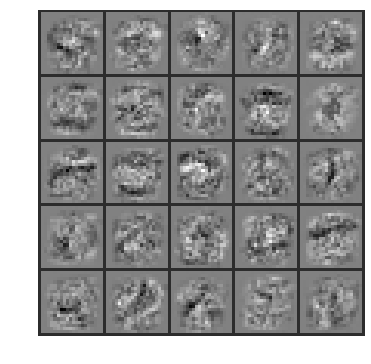

In [8]:
displayData(theta1[:, 1:])